# Pipeline de dados financeiros do setor elétrico

Este notebook implementa um pipeline completo de dados para extração, transformação, análise e visualização das demonstrações financeiras padronizadas (DFPs) das empresas de geração elétrica no Brasil, utilizando uma arquitetura de data lake em camadas (bronze, silver e gold).

Os objetivos iniciais do projeto estão descritos no README.md em https://github.com/andrecamatta/pgera/.

Após o tratamento dos dados que culminam na criação de um esquema em estrela na cada silver, são realizadas as seguintes análises após a construção da camada gold:

**Evolução Patrimonial**: Como evoluíram os ativos, passivos e patrimônio líquido das principais empresas do setor elétrico nos últimos anos?

**Rentabilidade**: Quais empresas apresentam melhores indicadores de rentabilidade (margens, ROA, ROE) e como esses indicadores evoluíram ao longo do tempo?

**Liquidez**: Como está a saúde financeira das empresas em termos de indicadores de liquidez e capacidade de pagamento?

**Benchmarking**: Como as empresas se comparam entre si em termos de performance financeira?

Para responder a estas questões, implementamos um pipeline completo em uma arquitetura de data lake com camadas bronze, silver e gold, utilizando o Google Cloud Storage como plataforma de armazenamento e Apache Spark para processamento distribuído (cluster Dataproc).

## Ingestão de Dados Financeiros

### Demonstrações Financeiras Padronizadas (DFPs)

Importação de bibliotecas e outras funções básicas

In [1]:
import os
import pandas as pd
import time
import zipfile
import requests
import io
from bs4 import BeautifulSoup
from datetime import datetime

def get_bronze_path(dataset):
    """Gera caminho para camada bronze"""
    return f"gs://pgera-bronze/{dataset}"

def get_silver_path(dataset):
    """Gera caminho para camada silver"""
    return f"gs://pgera-silver/{dataset}"

### Acesso ao FTP da CVM

Funções para listar e baixar arquivos disponíveis no repositório FTP da Comissão de Valores Mobiliários (CVM):

In [2]:
def get_ftp_files(ftp_url):
    """Lista arquivos disponíveis no FTP da CVM"""
    response = requests.get(ftp_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return [link.get_text() for link in soup.find_all('a') if 'DFP' in link.get_text().upper()]

def download_extract_zip(url, dest_folder):
    """Baixa e extrai arquivos ZIP"""
    os.makedirs(dest_folder, exist_ok=True)
    local_file = os.path.join(dest_folder, os.path.basename(url))
    
    # Download do arquivo
    with open(local_file, 'wb') as f:
        f.write(requests.get(url).content)
    
    # Extração de CSVs
    with zipfile.ZipFile(local_file) as z:
        return [z.extract(f, dest_folder) for f in z.namelist() if f.lower().endswith('.csv')]

### Processamento de demonstrações financeiras

Nesta seção, são apresentadas as funções responsáveis pelo processo de extração, transformação e carregamento (ETL) dos arquivos de Demonstrações Financeiras Padronizadas (DFPs) até a camada silver. O objetivo principal é estruturar os dados financeiros de forma consistente e padronizada para facilitar análises posteriores.

#### Principais etapas do processamento:

1. **Extração dos dados brutos**:
   - Os arquivos de DFPs são carregados a partir da camada bronze.

2. **Transformação dos dados**:
   - **Limpeza de dados**: Remoção de valores nulos, duplicados e inconsistências.
   - **Padronização**: Conversão de colunas para formatos consistentes (ex.: datas, valores monetários, etc.).
   - **Cálculos financeiros**: Algumas funções realizam cálculos complexos, como índices financeiros ou consolidação de balanços.

3. **Carregamento na camada silver**:
   - Após o processamento, os dados transformados são armazenados em uma camada intermediária (silver), que serve como base para análises mais avançadas ou para a construção de dashboards.

#### Detalhamento das funções implementadas na célula seguinte:

- **`process_csv`**:
  - Lê um arquivo CSV de demonstrações financeiras padronizadas (DFP) e o transforma em um DataFrame do Pandas.
  - Configura o delimitador, a codificação e os tipos de dados para garantir a leitura correta das colunas, como `CNPJ_CIA` e `CD_CVM`.

- **`process_year`**:
  - Processa todos os arquivos de DFPs de um ano específico, baixando-os do repositório FTP da CVM.
  - Extrai os arquivos ZIP diretamente na memória, lê os arquivos CSV contidos neles e concatena os dados em um único DataFrame.
  - Salva o resultado em formato Parquet na camada bronze.

- **`filter_companies_data`**:
  - Filtra os dados financeiros de acordo com uma lista de empresas fornecida (do setor elétrico).
  - Utiliza o nome das empresas para aplicar o filtro e retorna apenas os registros correspondentes.

- **`enrich_dataframe`**:
  - Adiciona colunas derivadas ao DataFrame, como o ano de referência (`year`) e o grupo de demonstrações financeiras (`GRUPO_DFP`).
  - Normaliza os valores de `GRUPO_DFP` para facilitar a categorização dos dados.

- **`consolidate_years`**:
  - Consolida os dados financeiros de múltiplos anos em um único DataFrame.
  - Filtra os dados por empresa, enriquece o DataFrame com colunas derivadas e garante que apenas as colunas comuns entre os anos sejam mantidas.
  - Salva o resultado consolidado na camada silver em formato Parquet.

Essas funções são executadas de forma sequencial para garantir que o pipeline de ETL seja eficiente e confiável, preparando os dados para análises financeiras detalhadas.

In [3]:
def process_csv(file_path):
    """Processa um único arquivo CSV de DFP"""
    df = pd.read_csv(
        file_path, 
        delimiter=';', 
        encoding='latin1',
        dtype={'CNPJ_CIA': str, 'CD_CVM': str}
    )
    return df

def process_year(year, ftp_url):
    """Processa todos os arquivos DFP de um ano específico"""
    bronze_path = get_bronze_path("dfps")
    
    files = [f for f in get_ftp_files(ftp_url) if str(year) in f]
    
    if not files:
        print(f"Nenhum arquivo encontrado para o ano {year}")
        return False
    
    all_dfs = []
    
    for file_name in files:
        file_url = ftp_url + file_name
        print(f"Processando: {file_url}")
        
        # Download direto para memória
        response = requests.get(file_url)
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_files = [f for f in z.namelist() if f.lower().endswith('.csv')]
            
            for csv_file in csv_files:
                with z.open(csv_file) as f:
                    df = pd.read_csv(
                        f,
                        delimiter=';',
                        encoding='latin1',
                        dtype={'CNPJ_CIA': str, 'CD_CVM': str}
                    )
                    if not df.empty:
                        all_dfs.append(df)
    
    if all_dfs:
        year_df = pd.concat(all_dfs, ignore_index=True)
        year_df.to_parquet(f"{bronze_path}/dfps_{year}.parquet", index=False)
        return True
    
    return False

def filter_companies_data(df, companies):
    # Filtra dados por empresa
    if companies is None or len(companies) == 0:
        return df
        
    mask = df['DENOM_CIA'].str.contains('|'.join(companies), case=False)
    filtered_df = df[mask]
    
    if filtered_df.empty:
        print("Aviso: Nenhuma empresa encontrada com os filtros fornecidos")
        return df
        
    return filtered_df

def enrich_dataframe(df):
    # Adiciona colunas derivadas ao DataFrame
    if df.empty:
        return df
    
    # Adiciona coluna de ano
    if 'DT_REFER' in df.columns:
        df['year'] = pd.to_datetime(df['DT_REFER']).dt.year
    
    # Extrai e normaliza grupo do DFP
    if 'GRUPO_DFP' not in df.columns and 'ARQUIVO' in df.columns:
        df['GRUPO_DFP'] = df['ARQUIVO'].str.extract(
            r'(BPA|BPP|DRE|DFC_MD|DFC_MI|DMPL|DRA|DVA)', expand=False)
        df.loc[df['GRUPO_DFP'].isin(['BPA', 'BPP']), 'GRUPO_DFP'] = 'BP'
    
    return df

def consolidate_years(years, companies):
    """Consolida dados de múltiplos anos"""
    silver_path = get_silver_path("dfps")
    
    all_dfs = []
    
    for year in years:
        df = pd.read_parquet(f"gs://pgera-bronze/dfps/dfps_{year}.parquet")
        print(f"Total de linhas lidas: {len(df)}")
        
        df = filter_companies_data(df, companies)
        print(f"Total de linhas após filtro: {len(df)}")
        
        df = enrich_dataframe(df)
        
        if '__index_level_0__' in df.columns:
            df = df.drop('__index_level_0__', axis=1)
        
        all_dfs.append(df)
    
    if all_dfs:
        common_columns = set.intersection(*[set(df.columns) for df in all_dfs])
        print(f"Colunas comuns encontradas: {len(common_columns)}")
        
        filtered_dfs = [df[list(common_columns)] for df in all_dfs]
        final_df = pd.concat(filtered_dfs, ignore_index=True)
        
        final_df.to_parquet(f"{silver_path}/dfps_consolidated.parquet", index=False)
        print(f"Dados consolidados salvos em: {silver_path}")

### Processamento completo de DFPs

Função principal que orquestra o pipeline de ingestão e processamento de DFPs para múltiplos anos:

- `process_dfps`: Coordena todo o processo de ingestão e ETL, desde o download dos arquivos FTP até a consolidação na camada silver
  - Parâmetros:
    - `first_year`: Primeiro ano a ser processado (padrão: 2010)
    - `last_year`: Último ano a ser processado (padrão: 2025)
    - `companies`: Lista de empresas a serem filtradas (padrão: principais empresas do setor elétrico)
  - Fluxo de Processamento:
    1. Download dos arquivos ZIP do FTP da CVM para cada ano
    2. Extração e processamento dos CSVs
    3. Persistência na camada bronze em formato Parquet
    4. Consolidação dos dados na camada silver
    5. Limpeza de arquivos temporários

In [4]:
def process_dfps(first_year=2010, last_year=2025, companies=None):
    """
    Processa demonstrações financeiras padronizadas (DFPs) para um intervalo de anos
    """
    start_time = time.time()
    ftp_url = 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/'
    
    # Configuração inicial
    companies = companies or [
        "Eletrobras", "Engie Brasil", "Neoenergia",
        "CPFL Energia", "Cemig", "Energisa", "Equatorial"
    ]
    
    # Processa cada ano
    processed_years = []
    for year in range(first_year, last_year + 1):
        print(f"\nProcessando ano {year}")
        if process_year(year, ftp_url):
            processed_years.append(year)
    
    if processed_years:
        print(f"\nConsolidando dados dos anos {processed_years}")
        consolidate_years(processed_years, companies)
        
        elapsed_time = time.time() - start_time
        print(f"Processamento concluído em {elapsed_time/60:.2f} minutos")
        return True
    
    
    return False


## Exploração e análise de dados

### Importações e configuração do ambiente

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, sum, expr

### Execução do pipeline de processamento

Ingestão e processamento das DFPs para o período de análise:

In [6]:
process_dfps(first_year=2020, last_year=2023)


Processando ano 2020


Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2020.zip

Processando ano 2021
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2021.zip

Processando ano 2022
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2022.zip

Processando ano 2023
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2023.zip

Consolidando dados dos anos [2020, 2021, 2022, 2023]
Total de linhas lidas: 1178536
Total de linhas após filtro: 37769
Total de linhas lidas: 1237654
Total de linhas após filtro: 37664
Total de linhas lidas: 1252084
Total de linhas após filtro: 37468
Total de linhas lidas: 1277883
Total de linhas após filtro: 37880
Colunas comuns encontradas: 31
Dados consolidados salvos em: gs://pgera-silver/dfps
Processamento concluído em 1.04 minutos


True

### Configuração do Apache Spark

Inicialização da sessão Spark para processamento distribuído com integração ao Google Cloud Storage:

In [7]:
def init_spark_session():
    spark = SparkSession.builder \
        .appName("PGERA Silver") \
        .config("spark.sql.warehouse.dir", "gs://pgera-silver/spark-warehouse") \
        .config("hive.metastore.warehouse.dir", "gs://pgera-silver/hive-warehouse") \
        .config("spark.hadoop.fs.defaultFS", "gs://pgera-silver") \
        .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", 
               "/home/andrecamatta/.config/gcloud/application_default_credentials.json") \
        .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
        .enableHiveSupport() \
        .getOrCreate()

    # Forçar criação no GCS com LOCATION explícito
    spark.sql("""
        CREATE DATABASE IF NOT EXISTS pgera_silver 
        LOCATION 'gs://pgera-silver/databases/pgera_silver.db'
    """)
    
    return spark

### Carregamento de dados em tabelas

Criação de tabelas externas no Hive a partir dos dados processados na camada silver.

O arquivo parquet é lido diretamente do Google Cloud Storage e as tabelas são criadas no Hive para facilitar consultas SQL posteriores.

In [8]:
def load_dfps_data(spark):
    # Apaga a tabela, se existir
    spark.sql("DROP TABLE IF EXISTS pgera_silver.dfps")
    # Cria uma tabela externa no Hive a partir do arquivo Parquet.

    ddl = """
        CREATE EXTERNAL TABLE IF NOT EXISTS pgera_silver.dfps (
        qt_acao_pref_tesouro DOUBLE,
        qt_acao_total_tesouro DOUBLE,
        coluna_df STRING,
        ds_conta STRING,
        vl_conta DOUBLE,
        cd_cvm STRING,
        id_doc DOUBLE,
        st_conta_fixa STRING,
        versao BIGINT,
        denom_cia STRING,
        tp_relat_aud STRING,
        cnpj_cia STRING,
        link_doc STRING,
        escala_moeda STRING,
        num_item_parecer_decl DOUBLE,
        qt_acao_total_cap_integr DOUBLE,
        dt_ini_exerc STRING,
        dt_receb STRING,
        qt_acao_ordin_cap_integr DOUBLE,
        txt_parecer_decl STRING,
        cd_conta STRING,
        qt_acao_ordin_tesouro DOUBLE,
        tp_parecer_decl STRING,
        categ_doc STRING,
        moeda STRING,
        dt_fim_exerc STRING,
        dt_refer STRING,
        `year` INT,
        ordem_exerc STRING,
        grupo_dfp STRING,
        qt_acao_pref_cap_integr DOUBLE
        )
        STORED AS PARQUET
        LOCATION 'gs://pgera-silver/dfps/';
        """

    # Executa o comando DDL
    spark.sql(ddl)
    # Informa que o banco de dados foi criado a partir do parquet
    print("Tabela dfps criada com sucesso!")


In [9]:
spark = init_spark_session()
# Cria o banco dados pgera caso não exista
dfps_df = load_dfps_data(spark)

25/04/11 10:56:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
25/04/11 10:57:04 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


Tabela dfps criada com sucesso!


### Criação de um datamart em esquema estrela
Criação de tabelas de dimensão e fato na camada silver. 

Optou-se em salvar o esquema na camada silver, pois esses dados serão utilizados para análises finais na camada gold.

Importante notar que pode haver várias versões de um DFP, a tabela fato é tratada nessa etapa para ter o valor somente da última versão.

In [10]:
def create_silver_star_schema(spark):
    # Cria e popula o schema estrela completo com dados da pgera_silver.dfps.

    base_path = "gs://pgera-silver/star_schema"

    # Cria o caminho com timestamp
    import time
    timestamp = int(time.time())
    base_path = f"gs://pgera-silver/star_schema_{timestamp}"
    
    # Apaga tabelas existentes
    for tabela in ["dim_empresa", "dim_tempo", "dim_metrica", "fato_dfp"]:
        spark.sql(f"DROP TABLE IF EXISTS pgera_silver.{tabela}")
    
    # Criar dimensão empresa
    spark.sql(f"""
        CREATE TABLE pgera_silver.dim_empresa
        LOCATION '{base_path}/dim_empresa'
        AS
        WITH ranked_data AS (
            SELECT
                cnpj_cia,
                denom_cia,
                ROW_NUMBER() OVER (
                    PARTITION BY cnpj_cia 
                    ORDER BY dt_refer DESC
                ) as rn
            FROM pgera_silver.dfps
            WHERE cnpj_cia IS NOT NULL
        )
        SELECT DISTINCT
            cnpj_cia as empresa_id,
            denom_cia as nome_pregao,
            'Energia Elétrica' as setor,
            'N/A' as segmento  -- Não classificado
        FROM ranked_data 
        WHERE rn = 1
    """)
    
    # Criar dimensão tempo
    spark.sql(f"""
        CREATE TABLE pgera_silver.dim_tempo
        LOCATION '{base_path}/dim_tempo'
        AS
        SELECT DISTINCT
            YEAR(dt_refer) as tempo_id,
            YEAR(dt_refer) as ano
        FROM pgera_silver.dfps
    """)
    
    # Criar dimensão métrica
    spark.sql(f"""
        CREATE TABLE pgera_silver.dim_metrica
        LOCATION '{base_path}/dim_metrica'
        AS
        SELECT DISTINCT
            md5(cd_conta) as metrica_id,
            cd_conta as codigo_conta,
            ds_conta as nome_conta,
            CASE 
                WHEN SUBSTR(cd_conta, 1, 1) = '1' OR 
                     LOWER(ds_conta) LIKE '%ativo%' THEN 'Ativo'
                WHEN SUBSTR(cd_conta, 1, 1) = '2' OR 
                     LOWER(ds_conta) LIKE '%passivo%' THEN 'Passivo'
                WHEN SUBSTR(cd_conta, 1, 1) = '3' OR 
                     LOWER(ds_conta) LIKE '%receita%' THEN 'Receita'
                WHEN SUBSTR(cd_conta, 1, 1) = '4' OR 
                     LOWER(ds_conta) LIKE '%despesa%' THEN 'Despesa'
                ELSE 'Outros'
            END as categoria
        FROM pgera_silver.dfps
        WHERE cd_conta IS NOT NULL
    """)
    
    # Criar tabela fato
    spark.sql(f"""
        CREATE TABLE pgera_silver.fato_dfp
        LOCATION '{base_path}/fato_dfp'
        COMMENT 'Fato de demonstrações financeiras'
        AS
        WITH latest_versions AS (
            SELECT
                cnpj_cia,
                YEAR(dt_refer) as tempo_id,
                cd_conta,
                MAX(versao) as max_versao
            FROM pgera_silver.dfps
            GROUP BY cnpj_cia, YEAR(dt_refer), cd_conta
        )
        SELECT
            d.cnpj_cia as empresa_id,
            YEAR(d.dt_refer) as tempo_id,
            m.metrica_id,
            d.vl_conta as valor,
            d.versao
        FROM pgera_silver.dfps d
        JOIN latest_versions lv 
            ON d.cnpj_cia = lv.cnpj_cia 
            AND YEAR(d.dt_refer) = lv.tempo_id
            AND d.cd_conta = lv.cd_conta
            AND d.versao = lv.max_versao
        JOIN pgera_silver.dim_metrica m ON d.cd_conta = m.codigo_conta
    """)
    
    # Mostra uma amostra da tabela fato
    spark.sql("SELECT * FROM pgera_silver.fato_dfp LIMIT 10").show()
    # Mostra uma amostra da dimensão empresa
    spark.sql("SELECT * FROM pgera_silver.dim_empresa LIMIT 10").show()
    # Mostra uma amostra da dimensão tempo
    spark.sql("SELECT * FROM pgera_silver.dim_tempo LIMIT 10").show()
    # Mostra uma amostra da dimensão métrica
    spark.sql("SELECT * FROM pgera_silver.dim_metrica LIMIT 10").show()
# Para executar a função:
create_silver_star_schema(spark)

25/04/11 10:57:06 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
25/04/11 10:57:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/04/11 10:57:18 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
25/04/11 10:57:22 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
25/04/11 10:57:27 WARN ResolveSessionCatalog: A Hive serde table will be created a

+------------------+--------+--------------------+---------+------+
|        empresa_id|tempo_id|          metrica_id|    valor|versao|
+------------------+--------+--------------------+---------+------+
|00.001.180/0001-26|    2020|7df48155c687c32df...| 650523.0|     1|
|00.001.180/0001-26|    2020|7df48155c687c32df...| 628904.0|     1|
|00.001.180/0001-26|    2020|7df48155c687c32df...|3887234.0|     1|
|00.001.180/0001-26|    2020|7df48155c687c32df...|4433566.0|     1|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
|17.155.730/0001-64|    2020|300d8067120586b2c...| 304869.0|     2|
+------------------+--------+--------------------+---------+------+

+------------------+--------------------+------

## Análises financeiras - camada gold

Esta seção detalha as análises financeiras avançadas realizadas sobre os dados processados e consolidados na camada Gold. O objetivo é extrair insights valiosos sobre a saúde financeira e o desempenho das entidades ao longo do tempo.

### Análise horizontal de balanços patrimoniais

A análise horizontal é uma técnica para avaliar a evolução das contas do Balanço Patrimonial (BP) entre diferentes períodos. Nesta etapa, são geradas tabelas que calculam a variação absoluta e percentual de cada conta do BP em relação a um período base (geralmente o ano anterior). Isso permite identificar tendências, crescimentos ou decréscimos significativos em ativos, passivos e patrimônio líquido.

A célula de código subsequente implementa a criação dessas estruturas na camada Gold. Primeiramente, ela estabelece o banco de dados `horizontal_analysis`. Em seguida, cria uma tabela de referência (`companies`) com os dados das empresas. Por fim, constrói a tabela principal (`assets_liabilities_analysis`), que busca os valores das contas relevantes do Balanço Patrimonial no esquema estrela da camada Silver e os organiza de forma pivotada, com cada ano como uma coluna, permitindo a comparação direta da evolução dos saldos anuais por empresa e conta. As tabelas resultantes são armazenadas na camada gold, prontas para consumo por ferramentas de BI ou relatórios gerenciais.

In [11]:
def create_horizontal_analysis_db(spark):
    # Apaga o banco para sobrescrever caso exista
    spark.sql("DROP DATABASE IF EXISTS horizontal_analysis CASCADE")
    
    # Cria o database especificando o local no GCS
    spark.sql("""
        CREATE DATABASE horizontal_analysis
        LOCATION 'gs://pgera-gold/horizontal_analysis'
    """)

def create_companies_table(spark):
    """
    Cria uma tabela na camada gold contendo empresas únicas e seus CNPJs.
    """
    # Apaga o banco se existir e recria
    spark.sql("""
        CREATE DATABASE IF NOT EXISTS horizontal_analysis
        LOCATION 'gs://pgera-gold/horizontal_analysis'
    """)
    
    # Cria a tabela com empresas únicas usando a dimensão empresa
    ddl = """
    CREATE EXTERNAL TABLE horizontal_analysis.companies
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/companies/'
    AS
    SELECT
        empresa_id as cnpj,
        nome_pregao as nome_empresa
    FROM pgera_silver.dim_empresa
    """
    
    # Executa o DDL
    spark.sql(ddl)
    
    print("Tabela de empresas criada com sucesso!")

def create_horizontal_analysis_table_al(spark):
    """
    Cria tabela de análise horizontal de ativos e passivos usando o esquema estrela.
    """
    # Obtém os anos disponíveis nos dados
    years_df = spark.sql("""
        SELECT DISTINCT tempo_id as year 
        FROM pgera_silver.dim_tempo 
        ORDER BY year
    """)
    years = [row.year for row in years_df.collect()]
    
    # Cria declarações CASE dinâmicas para os anos - CORRIGIDO para usar 'ano' e 'valor' da CTE
    year_cases = [
        f"MAX(CASE WHEN ano = {year} THEN valor END) as `{year}`"
        for year in years
    ]
    years_sql = ",\n        ".join(year_cases)
    
    # Query para criar a tabela com análise horizontal dos BPs
    ddl = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS horizontal_analysis.assets_liabilities_analysis
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/assets_liabilities_analysis/'
    AS
    WITH base_data AS (
        SELECT 
            e.empresa_id,
            e.nome_pregao,
            m.nome_conta as conta,
            f.tempo_id as ano,
            f.valor
        FROM pgera_silver.fato_dfp f
        JOIN pgera_silver.dim_empresa e ON f.empresa_id = e.empresa_id
        JOIN pgera_silver.dim_metrica m ON f.metrica_id = m.metrica_id
        WHERE m.categoria IN ('Ativo', 'Passivo')
        AND m.nome_conta IN (
            'Ativo Total',
            'Ativo Circulante',
            'Ativo Não Circulante',
            'Ativo Realizável a Longo Prazo',
            'Imobilizado',
            'Investimentos',
            'Intangível',
            'Passivo Total',
            'Passivo Circulante',
            'Passivo Não Circulante',
            'Patrimônio Líquido',
            'Patrimônio Líquido Consolidado'
        )
    )
    SELECT 
        empresa_id,
        nome_pregao,
        conta,
        {years_sql}
    FROM base_data
    GROUP BY empresa_id, nome_pregao, conta
    """
    
    # Executa o comando DDL
    spark.sql(ddl)
    
    print("Tabela de análise horizontal criada com sucesso!")
# Cria o banco de dados
create_horizontal_analysis_db(spark)

# Cria a tabela
create_companies_table(spark)

# Exemplo de uso
create_horizontal_analysis_table_al(spark)

# Para verificar os dados
spark.sql("""
    SELECT *
    FROM horizontal_analysis.assets_liabilities_analysis
    ORDER BY nome_pregao, conta
""").show(truncate=False)

Tabela de empresas criada com sucesso!


Tabela de análise horizontal criada com sucesso!
+------------------+--------------------------------+------------------------------+-----------+-----------+-----------+-----------+
|empresa_id        |nome_pregao                     |conta                         |2020       |2021       |2022       |2023       |
+------------------+--------------------------------+------------------------------+-----------+-----------+-----------+-----------+
|06.981.180/0001-16|CEMIG DISTRIBUICAO S.A.         |Ativo Circulante              |8092769.0  |8092769.0  |7760978.0  |6990889.0  |
|06.981.180/0001-16|CEMIG DISTRIBUICAO S.A.         |Ativo Não Circulante          |1.9350905E7|1.7048254E7|1.8421756E7|2.1396483E7|
|06.981.180/0001-16|CEMIG DISTRIBUICAO S.A.         |Ativo Realizável a Longo Prazo|1.0412285E7|7840985.0  |7387012.0  |9297093.0  |
|06.981.180/0001-16|CEMIG DISTRIBUICAO S.A.         |Ativo Total                   |2.5141023E7|2.5141023E7|2.5412645E7|2.7582566E7|
|06.981.180/0001-16|

In [12]:
import matplotlib.pyplot as plt
def analyze_balance_sheet_company(spark, cnpj, initial_year=2020, final_year=2021):
    # Realiza e visualiza análise horizontal do Balanço Patrimonial de uma empresa.
    # Fonte: horizontal_analysis.assets_liabilities_analysis (Camada Gold).
    
    # Ordem desejada para as contas no gráfico/tabela
    ordem_contas = [
        'Ativo Total', 'Ativo Circulante', 'Ativo Não Circulante',
        'Ativo Realizável a Longo Prazo', 'Investimentos', 'Imobilizado',
        'Intangível', 'Passivo Total', 'Passivo Circulante',
        'Passivo Não Circulante', 'Patrimônio Líquido',
        'Patrimônio Líquido Consolidado'
    ]
    # Mapeamento para ordenação SQL
    case_ordem_sql = "CASE conta " + " ".join([f"WHEN '{conta}' THEN {i}" for i, conta in enumerate(ordem_contas)]) + " ELSE 999 END"

    query = f"""
    SELECT
        nome_pregao,
        conta,
        `{initial_year}` as valor_inicial,
        `{final_year}` as valor_final,
        CASE
            WHEN `{initial_year}` IS NOT NULL AND `{initial_year}` <> 0 THEN ROUND((`{final_year}` / `{initial_year}` - 1) * 100, 2)
            ELSE NULL
        END as var_percent
    FROM horizontal_analysis.assets_liabilities_analysis
    WHERE empresa_id = '{cnpj}' AND `{initial_year}` IS NOT NULL AND `{final_year}` IS NOT NULL
    ORDER BY {case_ordem_sql}
    """

    pd_analise = spark.sql(query).toPandas()

    if pd_analise.empty:
        print(f"AVISO: Nenhum dado encontrado para CNPJ {cnpj} no período {initial_year}-{final_year}.")
        return None

    empresa = pd_analise['nome_pregao'].iloc[0]
    pd_analise = pd_analise.set_index('conta').drop('nome_pregao', axis=1)

    # Exibir tabela
    print(f"\n--- Análise Horizontal: {empresa} ({initial_year} vs {final_year}) ---")
    display(pd_analise)

    # Gerar gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(pd_analise.index, pd_analise['var_percent'], color='lightcoral')
    ax.set_title(f'Variação percentual por conta ({initial_year} vs {final_year})\n{empresa}', fontsize=14, weight='bold')
    ax.set_ylabel('Variação (%)', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10, labelright=False) # Rotação e tamanho
    ax.tick_params(axis='y', labelsize=10)
    ax.axhline(0, color='black', linewidth=0.8)

    # Adicionar rótulos de dados (simplificado)
    ax.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=9, weight='medium',
                    label_type='edge', # Coloca o rótulo na borda da barra
                    # Formatação condicional para números negativos (opcional, pode adicionar complexidade)
                    # labels=[f'{v:,.1f}%'.replace(',', '_').replace('.', ',').replace('_', '.') if pd.notna(v) else '' for v in pd_analise['var_percent']]
                    )


    plt.tight_layout()
    plt.show()

    return pd_analise

### Visualização de análises financeiras

Função para gerar análises comparativas e visualizações de balanços patrimoniais por empresa:


--- Análise Horizontal: EQUATORIAL S.A. (2022 vs 2023) ---


,valor_inicial,valor_final,var_percent
conta,,,
Ativo Total,90617397.0,103643452.0,14.37
Ativo Circulante,21690029.0,27952915.0,28.87
Ativo Não Circulante,68928098.0,75690537.0,9.81
Ativo Realizável a Longo Prazo,34516422.0,36346923.0,5.30
Investimentos,20353467.0,21674339.0,6.49
Imobilizado,5139309.0,7871114.0,53.16
Intangível,29245320.0,31447954.0,7.53
Passivo Total,90617397.0,103643452.0,14.37
Passivo Circulante,22099849.0,22099849.0,0.00


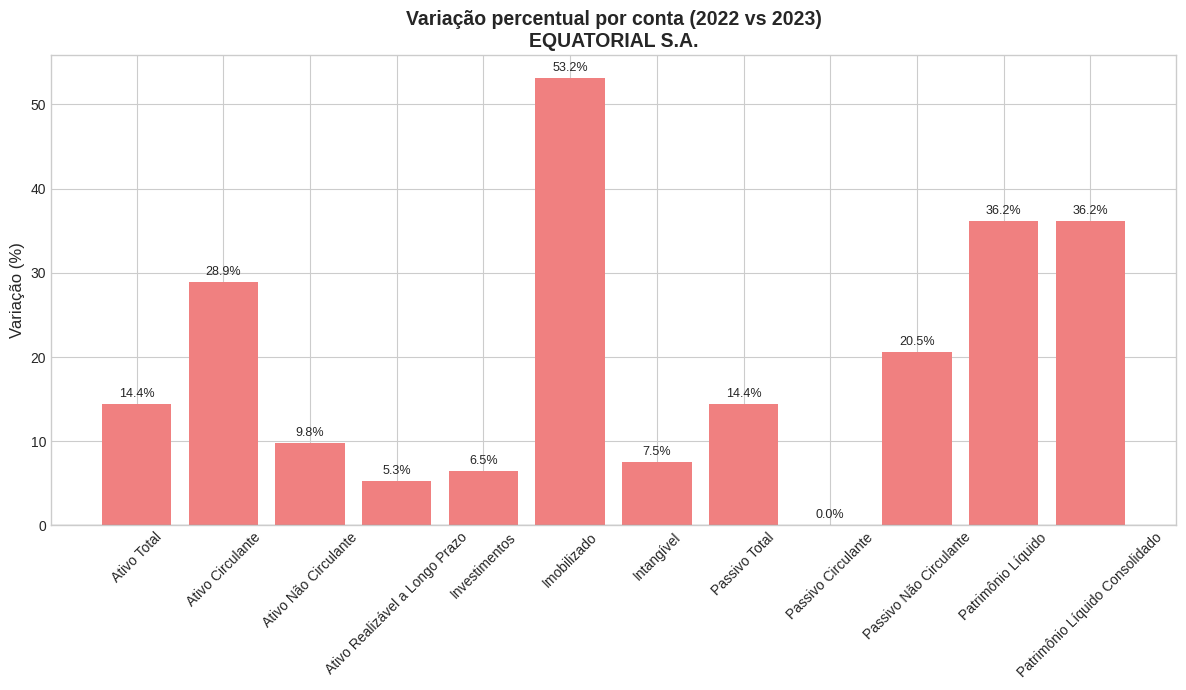

In [13]:
# Exemplo de uso
cnpj = "03.220.438/0001-73"
resultado = analyze_balance_sheet_company(spark, cnpj, 2022, 2023)

## Análise de demonstração de resultados (DRE) - camada gold

A análise de DRE é útil para entender a performance operacional e a lucratividade de uma empresa em um determinado período. Esta seção foca na criação de estruturas de dados na camada gold que facilitam a análise da evolução das receitas, custos, despesas e lucros ao longo do tempo.

### Criação de tabela para análise da DRE

Para permitir as análises, é necessário consolidar os dados da DRE em uma tabela específica.

A seguir, são realizadas as seguintes etapas:
1.  Buscar os dados relevantes da DRE (como Receita Líquida, Resultado Bruto, Lucro Líquido, etc.) a partir do esquema estrela já construído na camada Silver (`fato_dfp`, `dim_empresa`, `dim_metrica`).
2.  Identificar os anos disponíveis nos dados.
3.  Pivotar os valores anuais dessas contas, transformando cada ano em uma coluna separada na tabela final.
4.  Agrupar os resultados por empresa e conta da DRE.
5.  Salvar essa estrutura consolidada como uma tabela externa (`horizontal_analysis.income_statement_analysis`) na camada Gold, em formato Parquet, pronta para análises de rentabilidade e comparações temporais.

In [14]:
def create_dre_analysis_table_star_schema(spark):
   
    spark.sql("DROP TABLE IF EXISTS horizontal_analysis.income_statement_analysis")

    # Obtém os anos disponíveis na dimensão tempo
    years_df = spark.sql("""
        SELECT DISTINCT tempo_id as year
        FROM pgera_silver.dim_tempo
        ORDER BY year
    """)
    years = [row.year for row in years_df.collect()]

    # Cria declarações CASE dinâmicas para pivotar os anos
    year_cases = [
        f"MAX(CASE WHEN f.tempo_id = {year} THEN f.valor END) as `{year}`"
        for year in years
    ]
    years_sql = ",\n        ".join(year_cases)

    # Lista das contas DRE desejadas 
    dre_accounts = [
        'Receita de Venda de Bens e/ou Serviços',
        'Custo dos Bens e/ou Serviços Vendidos',
        'Resultado Bruto',
        'Despesas/Receitas Operacionais',
        'Resultado Antes do Resultado Financeiro e dos Tributos',
        'Resultado Financeiro',
        'Resultado Antes dos Tributos sobre o Lucro',
        'Imposto de Renda e Contribuição Social sobre o Lucro',
        'Resultado Líquido das Operações Continuadas',
        'Resultado Líquido de Operações Descontinuadas',
        'Lucro/Prejuízo Consolidado do Período',
        'Lucro/Prejuízo do Período'
    ]
    # Formata a lista para uso na cláusula IN do SQL
    dre_accounts_sql = ", ".join([f"'{acc}'" for acc in dre_accounts])

    # Query para criar a tabela usando o esquema estrela
    # Junta fato e dimensões, filtra pelas contas DRE e pivota por ano
    ddl = f"""
    CREATE EXTERNAL TABLE horizontal_analysis.income_statement_analysis
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/income_statement_analysis/'
    AS
    SELECT
        e.empresa_id as cnpj_cia,
        e.nome_pregao as denom_cia,
        m.nome_conta as conta,
        {years_sql}
    FROM pgera_silver.fato_dfp f
    JOIN pgera_silver.dim_empresa e ON f.empresa_id = e.empresa_id
    JOIN pgera_silver.dim_metrica m ON f.metrica_id = m.metrica_id
    WHERE m.nome_conta IN ({dre_accounts_sql})
    GROUP BY e.empresa_id, e.nome_pregao, m.nome_conta
    """

    # Executa o comando DDL
    spark.sql(ddl)

    print("Tabela de análise DRE (horizontal_analysis.income_statement_analysis) criada com sucesso.")

# Executa a função para criar a tabela de análise DRE
create_dre_analysis_table_star_schema(spark)

Tabela de análise DRE (horizontal_analysis.income_statement_analysis) criada com sucesso.


### Análise de rentabilidade - métricas essenciais

A análise de rentabilidade é vital para avaliar a eficiência com que uma empresa utiliza seus recursos para gerar lucro. Esta seção se concentra no cálculo e armazenamento de métricas chave que indicam a performance financeira sob diferentes perspectivas.

A seguir, é implementada a função `create_profitability_metrics(spark)`. O objetivo desta função é calcular e consolidar  indicadores de rentabilidade para cada empresa e ano, armazenando-os na camada gold para fácil acesso e análise. O processo envolve:

1.  **Seleção de contas:** Identifica e busca os valores de contas fundamentais (Receita Líquida, Lucro Bruto, Lucro Operacional, Lucro Líquido, Ativo Total, Patrimônio Líquido) do esquema estrela na camada Silver (`fato_dfp`, `dim_empresa`, `dim_metrica`).
2.  **Agregação anual:** Agrega esses valores por empresa e ano. A função também lida com variações nos nomes das contas (ex: 'Lucro/Prejuízo do Período' vs. 'Lucro/Prejuízo Consolidado do Período'), consolidando-os para garantir consistência.
3.  **Cálculo de métricas:** Calcula os seguintes indicadores de rentabilidade, tratando potenciais divisões por zero:
    *   **Margem bruta (%)**: (lucro bruto / receita líquida) * 100
    *   **Margem operacional (%)**: (lucro operacional / receita Líquida) * 100
    *   **Margem líquida (%)**: (lucro Líquido / receita Líquida) * 100
    *   **Retorno sobre ativos (ROA) (%)**: (lucro Líquido / ativo Total) * 100
    *   **Retorno sobre patrimônio líquido (ROE) (%)**: (lucro líquido / patrimônio líquido) * 100
4.  **Armazenamento na camada gold:** Salva tanto os valores base agregados quanto as métricas calculadas em uma nova tabela externa (`horizontal_analysis.profitability_metrics`) na camada gold, otimizada para consultas e visualizações posteriores.

In [15]:
def create_profitability_metrics(spark):
    
    spark.sql("DROP TABLE IF EXISTS horizontal_analysis.profitability_metrics")

    # --- Configuração ---
    target_table = "horizontal_analysis.profitability_metrics"
    target_location = "gs://pgera-gold/horizontal_analysis/profitability_metrics/"
    source_fact = "pgera_silver.fato_dfp"
    source_dim_empresa = "pgera_silver.dim_empresa"
    source_dim_metrica = "pgera_silver.dim_metrica"

    # Contas necessárias para buscar na fato
    accounts_to_aggregate = {
        'Receita de Venda de Bens e/ou Serviços': 'receita_liquida',
        'Resultado Bruto': 'lucro_bruto',
        'Resultado Antes do Resultado Financeiro e dos Tributos': 'lucro_operacional',
        'Lucro/Prejuízo do Período': 'lucro_liquido_periodo', # Nome temporário
        'Lucro/Prejuízo Consolidado do Período': 'lucro_liquido_consolidado', # Nome temporário
        'Ativo Total': 'ativo_total',
        'Patrimônio Líquido': 'patrimonio_liquido_base', # Nome temporário
        'Patrimônio Líquido Consolidado': 'patrimonio_liquido_consolidado' # Nome temporário
    }
    all_accounts_sql = ", ".join([f"'{acc}'" for acc in accounts_to_aggregate.keys()])

    # Cria expressões MAX(CASE...) para cada conta necessária
    aggregation_expressions = [
        f"MAX(CASE WHEN m.nome_conta = '{acc_name}' THEN f.valor ELSE 0 END) as {alias}"
        for acc_name, alias in accounts_to_aggregate.items()
    ]
    aggregation_sql = ",\n            ".join(aggregation_expressions)

    # --- Lógica de Cálculo de Métricas (metricas CTE) ---
    # Define as expressões para calcular cada métrica, tratando divisão por zero
    metric_calculations = {
        # Consolida Lucro Líquido e Patrimônio Líquido
        "lucro_liquido": "COALESCE(lucro_liquido_consolidado, lucro_liquido_periodo)",
        "patrimonio_liquido": "COALESCE(patrimonio_liquido_consolidado, patrimonio_liquido_base)",
        # Calcula Ratios
        "margem_bruta": "CASE WHEN receita_liquida = 0 OR receita_liquida IS NULL THEN NULL ELSE ROUND((lucro_bruto / receita_liquida) * 100, 2) END",
        "margem_operacional": "CASE WHEN receita_liquida = 0 OR receita_liquida IS NULL THEN NULL ELSE ROUND((lucro_operacional / receita_liquida) * 100, 2) END",
        "margem_liquida": "CASE WHEN receita_liquida = 0 OR receita_liquida IS NULL THEN NULL ELSE ROUND((COALESCE(lucro_liquido_consolidado, lucro_liquido_periodo) / receita_liquida) * 100, 2) END", # Usa lucro consolidado aqui também
        "roa": "CASE WHEN ativo_total = 0 OR ativo_total IS NULL THEN NULL ELSE ROUND((COALESCE(lucro_liquido_consolidado, lucro_liquido_periodo) / ativo_total) * 100, 2) END",
        "roe": "CASE WHEN COALESCE(patrimonio_liquido_consolidado, patrimonio_liquido_base) = 0 OR COALESCE(patrimonio_liquido_consolidado, patrimonio_liquido_base) IS NULL THEN NULL ELSE ROUND((COALESCE(lucro_liquido_consolidado, lucro_liquido_periodo) / COALESCE(patrimonio_liquido_consolidado, patrimonio_liquido_base)) * 100, 2) END"
    }
    # Seleciona as colunas base e adiciona os cálculos das métricas
    metric_calculation_sql = ",\n            ".join([f"{calc_func} as {alias}" for alias, calc_func in metric_calculations.items()])
    base_columns_for_metrics = [alias for alias in accounts_to_aggregate.values() if alias not in ["lucro_liquido_periodo", "lucro_liquido_consolidado", "patrimonio_liquido_base", "patrimonio_liquido_consolidado"]] # Colunas que não precisam de consolidação explícita

    # --- Query Final ---
    ddl = f"""
    CREATE EXTERNAL TABLE {target_table}
    STORED AS PARQUET
    LOCATION '{target_location}'
    AS
    WITH base_values AS (
        -- Agrega os valores necessários por empresa e ano
        SELECT
            f.empresa_id,
            e.nome_pregao as denom_cia,
            f.tempo_id as ano,
            {aggregation_sql}
        FROM {source_fact} f
        JOIN {source_dim_empresa} e ON f.empresa_id = e.empresa_id
        JOIN {source_dim_metrica} m ON f.metrica_id = m.metrica_id
        WHERE m.nome_conta IN ({all_accounts_sql})
        GROUP BY f.empresa_id, e.nome_pregao, f.tempo_id
    ),
    metricas AS (
        -- Calcula as métricas a partir dos valores agregados
        SELECT
            empresa_id as cnpj_cia, -- Mantém nome original da coluna
            denom_cia,
            ano,
            {', '.join(base_columns_for_metrics)}, -- Inclui colunas base
            {metric_calculation_sql} -- Adiciona métricas calculadas
        FROM base_values
    )
    SELECT
        cnpj_cia, denom_cia, ano,
        receita_liquida, lucro_bruto, lucro_operacional, lucro_liquido, -- Valores finais
        ativo_total, patrimonio_liquido, -- Valores finais
        margem_bruta, margem_operacional, margem_liquida, roa, roe -- Métricas finais
    FROM metricas
    ORDER BY denom_cia, ano
    """

    # Executa o comando DDL
    spark.sql(ddl)
    print(f"Tabela {target_table} criada com sucesso!")

# Executa a função para criar a tabela de métricas de rentabilidade
create_profitability_metrics(spark)


Tabela horizontal_analysis.profitability_metrics criada com sucesso!


### Visualização de métricas de rentabilidade

Função para gerar análises visuais da evolução das métricas de rentabilidade por empresa:

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 

def visualize_profitability_metrics(cnpjs=None, empresa=None, anos=None):
    # Construir a query baseada nos parâmetros
    where_clauses = []
    if cnpjs:
        # Formata a lista de CNPJs para a cláusula IN
        cnpjs_str = ", ".join([f"'{cnpj}'" for cnpj in cnpjs])
        where_clauses.append(f"cnpj_cia IN ({cnpjs_str})")
    elif empresa: # Usar 'elif' para não combinar filtro de CNPJ e nome solto
        where_clauses.append(f"denom_cia LIKE '%{empresa}%'")

    if anos:
        anos_str = ", ".join(map(str, anos))
        where_clauses.append(f"ano IN ({anos_str})")

    where_clause = "WHERE " + " AND ".join(where_clauses) if where_clauses else ""

    query = f"""
    SELECT *
    FROM horizontal_analysis.profitability_metrics
    {where_clause}
    ORDER BY denom_cia, ano
    """

    # Executar a query
    df = spark.sql(query)

    # Converter para pandas
    pd_df = df.toPandas()

    if pd_df.empty:
        print("Nenhum dado encontrado com os parâmetros especificados.")
        return None # Retornar None se vazio

    # Configurações de visualização
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True) # Usar subplots e sharex
    plt.subplots_adjust(hspace=0.4)
    axes = axes.flatten() # Achatando para facilitar iteração

    metrics_to_plot = {
        'margem_bruta': 'Margem Bruta (%)',
        'margem_liquida': 'Margem Líquida (%)',
        'roa': 'Retorno sobre Ativos - ROA (%)',
        'roe': 'Retorno sobre Patrimônio Líquido - ROE (%)'
    }

    # Plotar cada métrica
    for i, (metric, title) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        for name, group in pd_df.groupby('denom_cia'):
            ax.plot(group['ano'], group[metric], marker='o', linestyle='-', label=name)
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Percentual (%)')
        ax.grid(True, alpha=0.3)
        # --- AJUSTE DO EIXO X ---
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Força ticks inteiros
        if i >= 2: # Adiciona label do eixo X apenas nos gráficos inferiores
             ax.set_xlabel('Ano')

    # Adicionar legenda fora dos plots para evitar sobreposição
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=min(len(labels), 4)) # Legenda no topo

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta layout para não cortar a legenda superior
    plt.show()

    # Tabela de resumo
    print("\nTabela de Resumo:")
    summary_df = pd_df[[
        'denom_cia', 'ano', 'margem_bruta', 'margem_operacional',
        'margem_liquida', 'roa', 'roe'
    ]].sort_values(['denom_cia', 'ano'])
    display(summary_df)

    return summary_df 

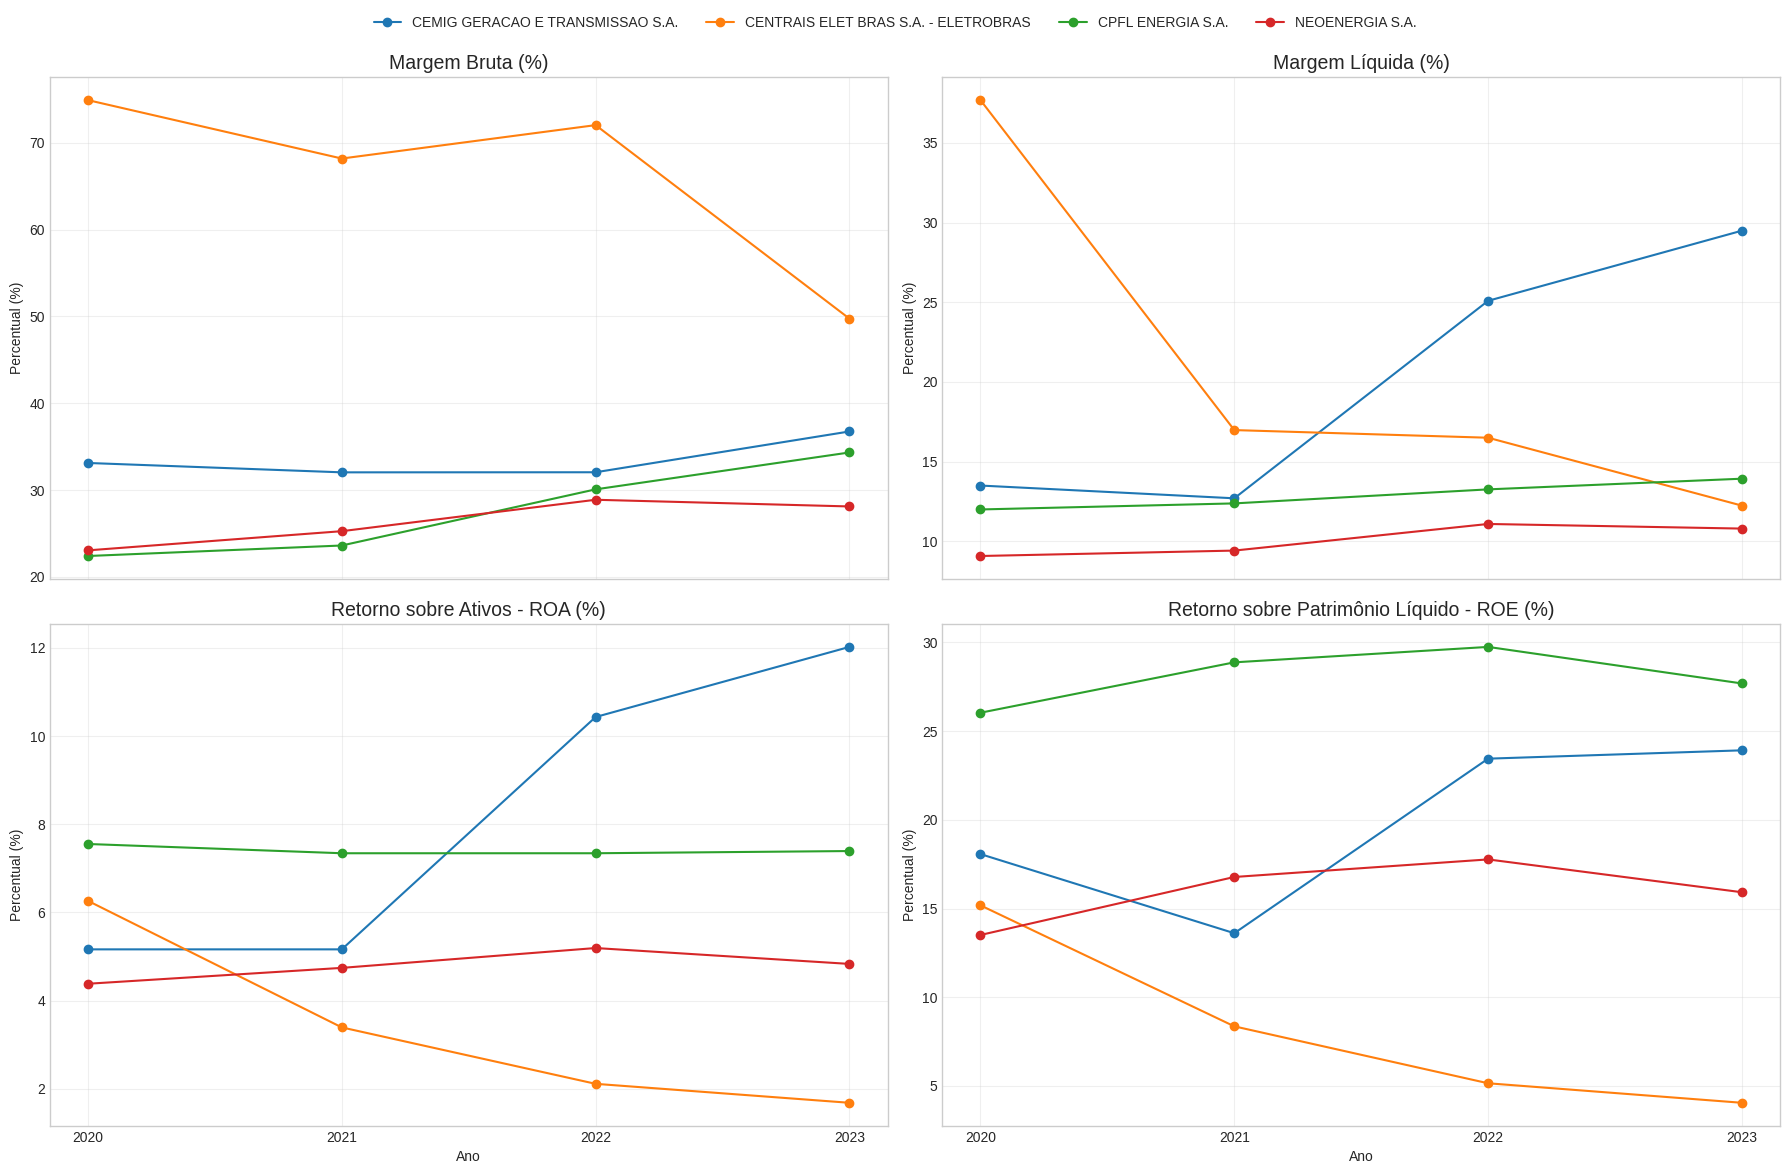


Tabela de Resumo:


,denom_cia,ano,margem_bruta,margem_operacional,margem_liquida,roa,roe
0,CEMIG GERACAO E TRANSMISSAO S.A.,2020,33.12,30.35,13.50,5.16,18.07
1,CEMIG GERACAO E TRANSMISSAO S.A.,2021,32.04,39.49,12.70,5.16,13.61
2,CEMIG GERACAO E TRANSMISSAO S.A.,2022,32.05,39.49,25.09,10.43,23.45
3,CEMIG GERACAO E TRANSMISSAO S.A.,2023,36.75,37.83,29.49,12.02,23.92
4,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2020,74.93,32.53,37.68,6.26,15.18
5,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2021,68.20,34.69,16.98,3.39,8.36
6,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2022,72.05,36.10,16.50,2.11,5.15
7,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2023,49.75,36.95,12.24,1.68,4.05
8,CPFL ENERGIA S.A.,2020,22.40,16.55,12.00,7.55,26.04
9,CPFL ENERGIA S.A.,2021,23.61,18.89,12.38,7.34,28.88


In [17]:
# Exemplo de uso - comparação das 4 empresas especificadas
cnpjs_selecionados = [
    "06.981.176/0001-58",
    "00.001.180/0001-26",
    "02.429.144/0001-93",
    "01.083.200/0001-18"
]
resultado_rentabilidade = visualize_profitability_metrics(cnpjs=cnpjs_selecionados)


## Análise comparativa de liquidez - camada gold

A análise de liquidez avalia a capacidade de uma empresa de cumprir suas obrigações de curto prazo. É um indicador da saúde financeira e da gestão do capital de giro. Esta seção foca na criação de uma tabela na camada gold que consolida os principais índices de liquidez, permitindo comparações entre empresas e ao longo do tempo.

### Criação de tabela de índices de liquidez

A célula de código seguinte define e executa a função `create_liquidity_metrics_table(spark)`. Esta função é responsável por gerar a tabela `horizontal_analysis.liquidity_metrics` na camada gold, seguindo estes passos:

1.  **Coleta de dados base:** Utiliza Spark SQL para buscar os valores das contas necessárias (Ativo Circulante, Ativo Total, Passivo Circulante, Passivo Não Circulante, Ativo Realizável a Longo Prazo) do esquema estrela na camada Silver (`fato_dfp`, `dim_empresa`, `dim_metrica`).
2.  **Agregação anual:** Agrupa esses valores por empresa e ano.
3.  **Cálculo dos índices:** Calcula os seguintes indicadores financeiros, tratando divisões por zero:
    *   **Liquidez corrente:** Mede a capacidade de pagar dívidas de curto prazo com ativos de curto prazo (Ativo Circulante / Passivo Circulante).
    *   **Liquidez imediata (estimada):** Uma estimativa da capacidade de pagamento imediato, calculada aqui como 10% do Ativo Circulante dividido pelo Passivo Circulante. *Nota: Este é um cálculo simplificado, pois o valor exato do caixa e equivalentes não foi isolado nesta etapa.*
    *   **Liquidez geral:** Avalia a capacidade de pagamento a longo prazo ((Ativo Circulante + Realizável a Longo Prazo) / (Passivo Circulante + Passivo Não Circulante)).
    *   **Endividamento percentual:** Indica a proporção do ativo total financiada por capital de terceiros ((Passivo Total / Ativo Total) * 100).
4.  **Armazenamento na camada gold:** Salva os valores base agregados e os índices calculados na tabela externa `horizontal_analysis.liquidity_metrics` (formato Parquet) na camada gold, pronta para análises comparativas e visualizações.

In [18]:
def create_liquidity_metrics_table(spark):
    
    # Apaga a tabela se existir
    spark.sql("DROP TABLE IF EXISTS horizontal_analysis.liquidity_metrics")

    # Query SQL para criar a tabela de métricas de liquidez usando o esquema estrela
    ddl = """
    CREATE EXTERNAL TABLE horizontal_analysis.liquidity_metrics
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/liquidity_metrics/'
    AS
    WITH base_data AS (
        -- Agrega os valores necessários por empresa e ano a partir do esquema estrela
        SELECT
            f.empresa_id,
            e.nome_pregao as denom_cia,
            f.tempo_id as ano,
            MAX(CASE WHEN m.nome_conta = 'Ativo Circulante' THEN f.valor ELSE 0 END) as ativo_circulante,
            MAX(CASE WHEN m.nome_conta = 'Ativo Total' THEN f.valor ELSE 0 END) as ativo_total,
            MAX(CASE WHEN m.nome_conta = 'Passivo Circulante' THEN f.valor ELSE 0 END) as passivo_circulante,
            MAX(CASE WHEN m.nome_conta = 'Passivo Não Circulante' THEN f.valor ELSE 0 END) as passivo_nao_circulante,
            MAX(CASE WHEN m.nome_conta = 'Ativo Realizável a Longo Prazo' THEN f.valor ELSE 0 END) as realizavel_longo_prazo
        FROM pgera_silver.fato_dfp f
        JOIN pgera_silver.dim_empresa e ON f.empresa_id = e.empresa_id
        JOIN pgera_silver.dim_metrica m ON f.metrica_id = m.metrica_id
        WHERE m.nome_conta IN (
            'Ativo Circulante', 'Ativo Total', 'Passivo Circulante',
            'Passivo Não Circulante', 'Ativo Realizável a Longo Prazo'
        )
        GROUP BY f.empresa_id, e.nome_pregao, f.tempo_id
    ),
    indicadores AS (
        -- Calcula os indicadores de liquidez
        SELECT
            empresa_id as cnpj_cia, -- Mantém nome original da coluna
            denom_cia,
            ano,
            ativo_circulante,
            ativo_total,
            passivo_circulante,
            passivo_nao_circulante,
            realizavel_longo_prazo,
            -- Índice de Liquidez Corrente
            CASE WHEN passivo_circulante = 0 OR passivo_circulante IS NULL THEN NULL
                 ELSE ROUND(ativo_circulante / passivo_circulante, 2) END as liquidez_corrente,
            -- Índice de Liquidez Imediata (Estimativa usando 10% do ativo circulante)
            CASE WHEN passivo_circulante = 0 OR passivo_circulante IS NULL THEN NULL
                 ELSE ROUND((ativo_circulante * 0.1) / passivo_circulante, 2) END as liquidez_imediata,
            -- Índice de Liquidez Geral
            CASE WHEN (passivo_circulante + passivo_nao_circulante) = 0 OR
                      (passivo_circulante IS NULL AND passivo_nao_circulante IS NULL) THEN NULL
                 ELSE ROUND((ativo_circulante + COALESCE(realizavel_longo_prazo, 0)) /
                           (passivo_circulante + passivo_nao_circulante), 2) END as liquidez_geral,
            -- Índice de Endividamento
            CASE WHEN ativo_total = 0 OR ativo_total IS NULL THEN NULL
                 ELSE ROUND(((passivo_circulante + passivo_nao_circulante) / ativo_total) * 100, 2) END as endividamento_percentual
        FROM base_data
    )
    SELECT *
    FROM indicadores
    ORDER BY denom_cia, ano
    """

    # Executa o comando DDL
    spark.sql(ddl)

    print("Tabela de métricas de liquidez (horizontal_analysis.liquidity_metrics) criada com sucesso.")

# Executa a função para criar a tabela de métricas de liquidez
create_liquidity_metrics_table(spark)

Tabela de métricas de liquidez (horizontal_analysis.liquidity_metrics) criada com sucesso.


### Visualização de indicadores de liquidez

Função para gerar análises visuais da evolução dos indicadores de liquidez por empresa:

In [19]:
def visualize_liquidity_metrics(spark, cnpjs_filter, anos=None):
    if not cnpjs_filter:
        print("Erro: É necessário fornecer uma lista de CNPJs para filtrar.")
        return None

    # Formata a lista de CNPJs para a cláusula IN
    cnpjs_str = ", ".join([f"'{cnpj}'" for cnpj in cnpjs_filter])
    where_clauses = [f"cnpj_cia IN ({cnpjs_str})"]

    if anos:
        anos_str = ", ".join(map(str, anos))
        where_clauses.append(f"ano IN ({anos_str})")

    where_clause = "WHERE " + " AND ".join(where_clauses)

    query = f"""
    SELECT *
    FROM horizontal_analysis.liquidity_metrics
    {where_clause}
    ORDER BY denom_cia, ano
    """

    pd_df = spark.sql(query).toPandas()

    if pd_df.empty:
        print("Nenhum dado encontrado com os parâmetros especificados.")
        return None

    metrics_to_plot = {
        'liquidez_corrente': ('Índice de Liquidez Corrente', 1),
        'liquidez_imediata': ('Índice de Liquidez Imediata (Estimado)', 0.2),
        'liquidez_geral': ('Índice de Liquidez Geral', 1),
        'endividamento_percentual': ('Percentual de Endividamento', None) # Sem linha de referência
    }

    num_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(nrows=(num_metrics + 1) // 2, ncols=2, figsize=(18, 6 * ((num_metrics + 1) // 2)), sharex=True)
    axes = axes.flatten() # Transforma em array 1D para fácil iteração
    plt.subplots_adjust(hspace=0.4, wspace=0.2) # Ajusta espaçamento

    # Agrupa por empresa para plotar linhas separadas
    grouped = pd_df.groupby('denom_cia')

    for i, (metric, (title, ref_line)) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        for name, group in grouped:
            ax.plot(group['ano'], group[metric], marker='o', linestyle='-', label=name)

        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Valor' if metric != 'endividamento_percentual' else 'Percentual (%)')
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Garante anos inteiros no eixo X

        if ref_line is not None:
            ax.axhline(y=ref_line, color='r', linestyle='--', alpha=0.5, label=f'Referência ({ref_line})')

        # Adiciona label do eixo X apenas nos gráficos inferiores
        if i >= len(axes) - 2: # Ajusta índice para considerar nrows
             ax.set_xlabel('Ano')

    # Remove eixos extras se o número de métricas for ímpar
    if num_metrics % 2 != 0:
        fig.delaxes(axes[-1])

    # Adiciona legenda fora dos plots
    handles, labels = axes[0].get_legend_handles_labels()
    # Remove duplicatas na legenda (caso haja linhas de referência com mesmo label)
    unique_labels = {}
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels[l] = h
    fig.legend(unique_labels.values(), unique_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=min(len(unique_labels), 4))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para legenda e labels
    plt.show()

    # Tabela de resumo
    print("\nTabela de Resumo:")
    summary_df = pd_df[[
        'denom_cia', 'ano', 'liquidez_corrente', 'liquidez_imediata',
        'liquidez_geral', 'endividamento_percentual'
    ]].sort_values(['denom_cia', 'ano'])
    display(summary_df) 

    return summary_df

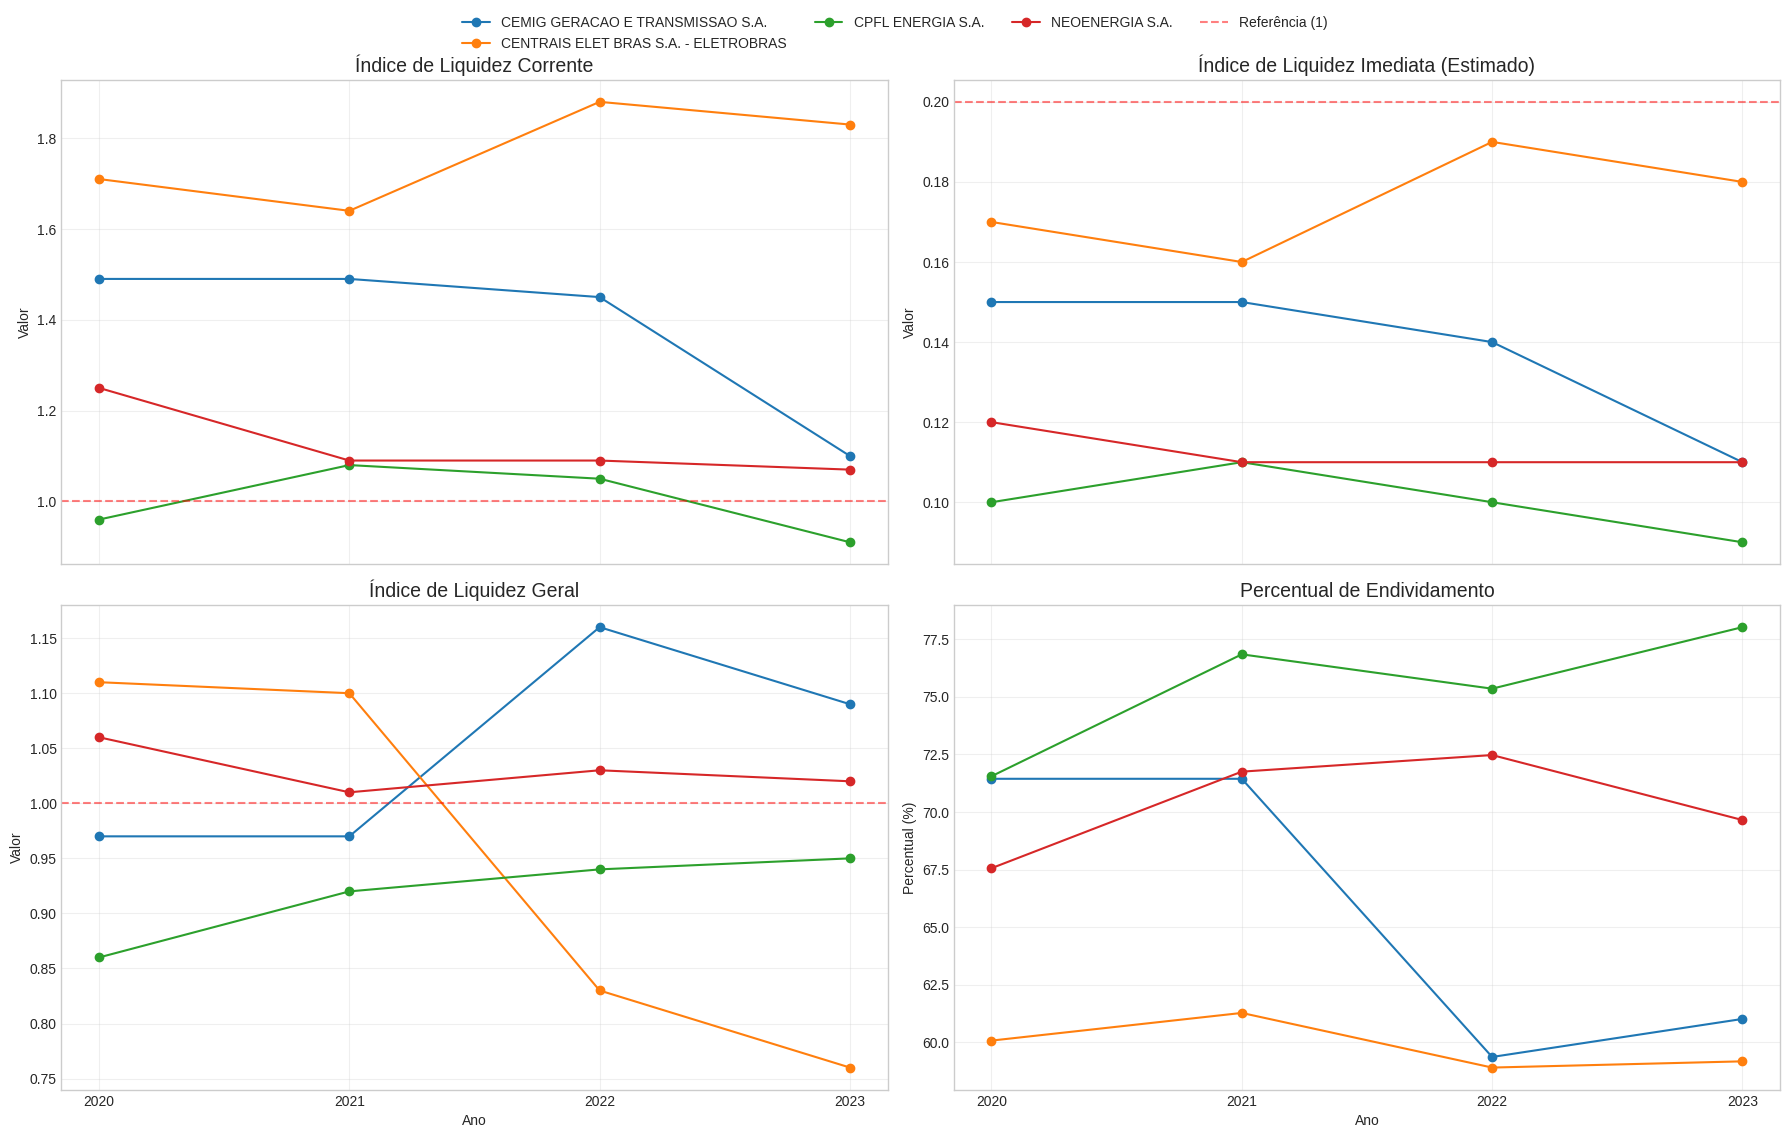


Tabela de Resumo:


,denom_cia,ano,liquidez_corrente,liquidez_imediata,liquidez_geral,endividamento_percentual
0,CEMIG GERACAO E TRANSMISSAO S.A.,2020,1.49,0.15,0.97,71.44
1,CEMIG GERACAO E TRANSMISSAO S.A.,2021,1.49,0.15,0.97,71.44
2,CEMIG GERACAO E TRANSMISSAO S.A.,2022,1.45,0.14,1.16,59.37
3,CEMIG GERACAO E TRANSMISSAO S.A.,2023,1.10,0.11,1.09,61.02
4,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2020,1.71,0.17,1.11,60.08
5,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2021,1.64,0.16,1.10,61.28
6,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2022,1.88,0.19,0.83,58.91
7,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2023,1.83,0.18,0.76,59.18
8,CPFL ENERGIA S.A.,2020,0.96,0.10,0.86,71.55
9,CPFL ENERGIA S.A.,2021,1.08,0.11,0.92,76.84


In [20]:
# Exemplo de uso - análise de liquidez para empresas do setor
esultado_liquidez = visualize_liquidity_metrics(spark, cnpjs_filter=cnpjs_selecionados)

## Dashboard financeiro comparativo

Função para gerar um painel comparativo completo entre duas empresas:

In [21]:
def generate_company_comparison_dashboard(cnpj1, cnpj2, year):

    # Query para obter dados combinados
    query = f"""
    WITH company_metrics AS (
        SELECT
            p.cnpj_cia,
            p.denom_cia,
            p.receita_liquida/1000000 as receita_liquida_mm,
            p.lucro_liquido/1000000 as lucro_liquido_mm,
            p.margem_bruta,
            p.margem_liquida,
            p.roa,
            p.roe,
            l.liquidez_corrente,
            l.liquidez_geral,
            l.endividamento_percentual
        FROM horizontal_analysis.profitability_metrics p
        JOIN horizontal_analysis.liquidity_metrics l
            ON p.cnpj_cia = l.cnpj_cia AND p.ano = l.ano
        WHERE p.cnpj_cia IN ('{cnpj1}', '{cnpj2}')
        AND p.ano = {year}
    )
    SELECT *
    FROM company_metrics
    """

    df = spark.sql(query).toPandas()

    if df.empty or len(df) < 2:
        print("Dados insuficientes para comparação.")
        return

    # Preparar dados para visualização
    metrics = {
        'Rentabilidade': ['margem_bruta', 'margem_liquida', 'roa', 'roe'],
        'Liquidez': ['liquidez_corrente', 'liquidez_geral', 'endividamento_percentual']
    }

    # Criar visualização
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot de rentabilidade 
    df_rentabilidade = df.set_index('denom_cia')[metrics['Rentabilidade']].T
    df_rentabilidade.plot(kind='bar', ax=ax1)
    ax1.set_title('Métricas de Rentabilidade (%)')
    ax1.set_xticklabels(['Margem Bruta', 'Margem Líquida', 'ROA', 'ROE'], rotation=45, ha='right')
    ax1.legend(title=None) # Remove o título da legenda se houver

    df_liquidez_plot = df.set_index('denom_cia')[metrics['Liquidez']].T.copy()
    # Dividir o endividamento por 100 na cópia para o plot
    df_liquidez_plot.loc['endividamento_percentual'] = df_liquidez_plot.loc['endividamento_percentual'] / 100

    # Plotar usando os dados modificados
    df_liquidez_plot.plot(kind='bar', ax=ax2)
    ax2.set_title('Métricas de Liquidez')
    # Ajustar o rótulo do eixo X para refletir a mudança de escala apenas visualmente
    ax2.set_xticklabels(['Liquidez Corrente', 'Liquidez Geral', 'Endividamento (/100)'], rotation=45, ha='right')
    ax2.legend(title=None) # Remove o título da legenda se houver
    

    # Configurações gerais
    plt.suptitle(f'Comparativo {df.denom_cia.iloc[0]} vs {df.denom_cia.iloc[1]} - {year}', fontsize=16, y=1.02) # Ajuste y para espaço
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajusta para o supertítulo
    plt.show()

    # Tabela resumo (usa o DataFrame original 'df' com o endividamento em %)
    summary = df[[
        'denom_cia', 'receita_liquida_mm', 'lucro_liquido_mm',
        'margem_bruta', 'margem_liquida', 'roa', 'roe',
        'liquidez_corrente', 'liquidez_geral', 'endividamento_percentual' 
    ]].set_index('denom_cia')

    summary.columns = [
        'Receita Líquida (MM)', 'Lucro Líquido (MM)',
        'Margem Bruta (%)', 'Margem Líquida (%)', 'ROA (%)', 'ROE (%)',
        'Liquidez Corrente', 'Liquidez Geral', 'Endividamento (%)' 
    ]

    print("\nResumo Financeiro:\n")
    

    return summary

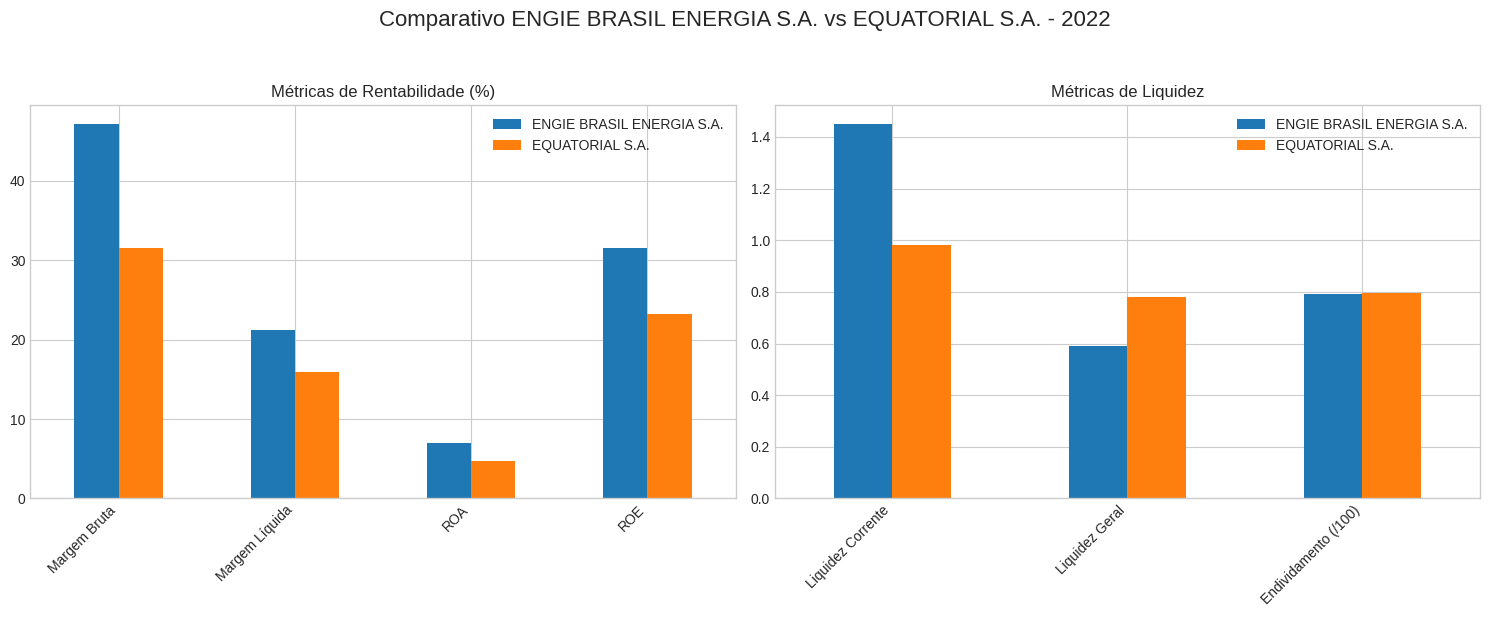


Resumo Financeiro:



,Receita Líquida (MM),Lucro Líquido (MM),Margem Bruta (%),Margem Líquida (%),ROA (%),ROE (%),Liquidez Corrente,Liquidez Geral,Endividamento (%)
denom_cia,,,,,,,,,
ENGIE BRASIL ENERGIA S.A.,12.540673,2.664568,47.14,21.25,6.98,31.57,1.45,0.59,79.34
EQUATORIAL S.A.,27.132507,4.302509,31.57,15.86,4.75,23.17,0.98,0.78,79.51


In [22]:
cnpj_eletrobras = "03.220.438/0001-73"  
cnpj_engie = "02.474.103/0001-19"  

generate_company_comparison_dashboard(cnpj_eletrobras, cnpj_engie, 2022)

## Resumo e conclusões

Este notebook implementou um pipeline completo de análise financeira das empresas do setor elétrico brasileiro, incluindo:

1. **Ingestão e processamento**: Extração automática de DFPs da CVM e transformação dos dados
2. **Análise do balanço patrimonial**: Evolução de ativos e passivos ao longo do tempo
3. **Análise da DRE**: Métricas de rentabilidade e eficiência operacional
4. **Indicadores de liquidez**: Avaliação da saúde financeira das empresas
5. **Comparativos entre empresas**: Dashboard para análise comparativa completa

Os resultados obtidos permitem compreender melhor o desempenho financeiro das empresas de geração elétrica no Brasil, identificando tendências e padrões importantes para a tomada de decisão no setor.

In [23]:
# Encerrar a sessão Spark quando finalizar
spark.stop()